In [70]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MECD/2º\ ano/Tese/Implementação

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MECD/2º ano/Tese/Implementação


In [71]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [72]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-15).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2019.20200218-1).
texlive-latex-extra is already the newest version (2019.202000218-1).
texlive-latex-recommended is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [73]:
!pip install SciencePlots

In [74]:
import joblib
import time

import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.pipeline import Pipeline

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
import scienceplots
plt.style.use("science")
import seaborn as sns

# Functions

In [75]:
def generate_handling_times(n_ships, n_berths, handling_interval, efficiency_interval):
        handling_times = np.random.uniform(low=handling_interval[0], high=handling_interval[1], size=(n_ships, n_berths))
        berth_hadling_efficiency = np.random.uniform(low=efficiency_interval[0], high=efficiency_interval[1], size=n_berths)
        handling_times = np.apply_along_axis(lambda x: x * berth_hadling_efficiency, axis=1, arr=handling_times)
        return handling_times

def generate_arrival_times(n_ships, n_berths, traffic_intensity):
        arrival_times = np.random.uniform(low=0, high=traffic_intensity * n_ships / n_berths, size=n_ships)
        return arrival_times

In [76]:
# get samples to predict from a timestamp corresponding to the execution moment
def get_scenario(exec_moment: pd.Timestamp,
                 voyages_df: pd.DataFrame,
                 rtt_pred_model: Pipeline,
                 prioritize=True):

    # get current vessels voyages from current_index
    current_voyages_samples = voyages_df.groupby(level=0, sort=False, group_keys=False)\
                                        .apply(lambda x: x.loc[x.index.get_level_values(1) <= exec_moment].last_valid_index()
                                               if len(x.loc[x.index.get_level_values(1) == exec_moment]) > 0 else np.NaN)\
                                        .dropna()\
                                        .apply(lambda x: voyages_df.loc[x])

    vessels_ids = current_voyages_samples["vessel"].values
    lengths = current_voyages_samples["Length"].values
    input_vars = current_voyages_samples[["LON", "LAT", "SOG", "COG", "distanceToPort"]].values

    # get remaining travel time predictions
    rtt_preds = rtt_pred_model.predict(input_vars)

    # generate handling times
    handling_times = np.empty(rtt_preds.shape)
    rng = np.random.RandomState(12345)
    handling_times[lengths < 200] = rng.normal(loc=9, scale=6, size=handling_times[lengths < 200].shape)
    handling_times[(lengths >= 200) & (lengths < 300)] = rng.normal(loc=21, scale=9,
                                                                    size=handling_times[(lengths >= 200)
                                                                                        & (lengths < 300)].shape)
    handling_times[lengths >= 300] = rng.normal(loc=32, scale=8,
                                                size=handling_times[lengths >= 300].shape)

    priorities = np.ones(vessels_ids.shape[0])
    if prioritize:
      priorities[(lengths >= 200) & (lengths < 300)] = 2
      priorities[lengths >= 300] = 3

    return vessels_ids, rtt_preds/60, np.abs(handling_times), priorities

In [77]:
class LogisticRegression(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(start_dim=0),
            nn.Linear(input_dim, output_dim),
            nn.Sigmoid()
        )

    def set_weights(self, parameters):
        current_n = 0
        for p in self.model.parameters():
            n_layer_weights = p.data.numel()
            layer_weights = parameters[current_n:current_n+n_layer_weights]
            layer_weights = np.reshape(layer_weights, newshape=p.shape)

            p.data = nn.parameter.Parameter(torch.from_numpy(layer_weights))
            p.requires_grad = False
            current_n = n_layer_weights
        return None


    def forward(self, x):
        tensor = torch.from_numpy(x)
        return self.model(tensor)

In [78]:
class BerthAllocator:

  def __init__(self,
               vessels_ids,
               arrival_times,
               handling_times,
               priorities,
               init_berth_occupancy,
               policy_model):

    arrivals_argsort = np.argsort(arrival_times)

    self.vessels_ids = vessels_ids[arrivals_argsort]
    self.arrival_times = arrival_times[arrivals_argsort]
    self.handling_times = handling_times[arrivals_argsort]
    self.priorities = priorities[arrivals_argsort]

    self.init_berth_occupancy = init_berth_occupancy

    self.policy_model = policy_model
    self.n_input_ships = int(self.policy_model.model[1].in_features/2)


  def get_policy_input(self, non_berthed_vessels_arrivals, non_berthed_vessels_handling):

    # convert negative values to 0
    non_berthed_vessels_arrivals[non_berthed_vessels_arrivals < 0] = 0

    # pad input if the number of vessels is lower than the policy input
    if self.n_input_ships > non_berthed_vessels_arrivals.shape[0]:
      pad_width = self.n_input_ships - non_berthed_vessels_arrivals.shape[0]
      input_arrival_times = np.pad(non_berthed_vessels_arrivals, (0, pad_width), "median")
      input_handling_times = np.pad(non_berthed_vessels_handling, (0, pad_width), "median")
    else:
      input_arrival_times = non_berthed_vessels_arrivals[:self.n_input_ships]
      input_handling_times = non_berthed_vessels_handling[:self.n_input_ships]

    # join the arrival and hadling times of vessels
    return np.hstack((input_arrival_times, input_handling_times))

  def simulate(self, weights):

    # set weights of policy model
    self.policy_model.set_weights(weights)

    # identify which vessels to berth
    vessels_to_berth = np.repeat(True, self.vessels_ids.shape[0])

    # copy to maintain original arrays
    arrival_times = np.copy(self.arrival_times)
    berth_occupancy = np.copy(self.init_berth_occupancy)

    # save berth plan information for each vessel
    berth_plan = pd.DataFrame(columns=["Priority", "ArrivalTime", "BerthingTime", "BerthingPosition", "HandlingTime"],
                              index=self.vessels_ids)
    berth_plan["Priority"] = self.priorities
    berth_plan["ArrivalTime"] = self.arrival_times

    i = 0
    while vessels_to_berth.any():

      if not (berth_occupancy <= 0).any():
            min_berth_occupancy = np.min(berth_occupancy)
            arrival_times -= min_berth_occupancy
            berth_occupancy -= min_berth_occupancy
            i += min_berth_occupancy

      # get empty berths
      empty_berths = np.where(berth_occupancy <= 0)[0]

      for empty_berth in empty_berths:

        if not vessels_to_berth.any():
          break

        # get non_berthed_vessels_info
        non_berthed_vessels_ids = self.vessels_ids[vessels_to_berth]
        non_berthed_vessels_arrivals = arrival_times[vessels_to_berth]
        non_berthed_vessels_handling = self.handling_times[vessels_to_berth, empty_berth]

        # get vessel to berth
        policy_input = self.get_policy_input(non_berthed_vessels_arrivals, non_berthed_vessels_handling)
        probs = self.policy_model.forward(policy_input)
        valid_output_size = np.min([non_berthed_vessels_arrivals.shape[0], self.n_input_ships])
        vessel_to_berth = np.argmax(probs[:valid_output_size]).item()

        # update berth plan info
        vessel_to_berth_id = non_berthed_vessels_ids[vessel_to_berth]
        vessel_to_berth_handling = non_berthed_vessels_handling[vessel_to_berth]
        vessel_to_berth_arrival = non_berthed_vessels_arrivals[vessel_to_berth]
        berth_plan.loc[vessel_to_berth_id, ["BerthingTime", "BerthingPosition", "HandlingTime"]] = \
                  [np.max([0, vessel_to_berth_arrival])+i, empty_berth, vessel_to_berth_handling]

        # update simulation info
        berth_occupancy[empty_berth] = np.max([0, vessel_to_berth_arrival]) + vessel_to_berth_handling
        berthed_vessel_index = np.where(self.vessels_ids == vessel_to_berth_id)[0][0]
        vessels_to_berth[berthed_vessel_index] = False

      i += 1
      arrival_times -= 1
      berth_occupancy -= 1

    return berth_plan

In [79]:
class BerthPlanEvaluator:

  def __init__(self, costs_agg, costs_weights):

    self.costs_agg = costs_agg
    self.costs_weights = costs_weights

  def get_costs(self, berth_plan, initial_berth_occupancy, partial_costs=False):

    waiting_times = berth_plan["BerthingTime"].values - berth_plan["ArrivalTime"].values
    turnaround_times = waiting_times + berth_plan["HandlingTime"].values

    max_moment = np.max(berth_plan["BerthingTime"].values + berth_plan["HandlingTime"].values)

    idle_times = berth_plan.groupby("BerthingPosition", sort=True, group_keys=False) \
                            .apply(lambda x: np.max(x["BerthingTime"] + x["HandlingTime"])
                                             - x["BerthingTime"].min()
                                             - x["HandlingTime"].sum())

    waiting_time = self.costs_agg[0](waiting_times)
    turnaround_time = self.costs_agg[1](turnaround_times)
    idle_time = self.costs_agg[2](idle_times)

    overall_cost = self.costs_weights[0]*self.costs_agg[0](waiting_times*berth_plan["Priority"].values)\
                  + self.costs_weights[1]*self.costs_agg[1](turnaround_times*berth_plan["Priority"].values)\
                  + self.costs_weights[2]*self.costs_agg[2](idle_times)

    if not partial_costs:
      return overall_cost

    return overall_cost, waiting_time, turnaround_time, idle_time

In [80]:
class CrossEntropyMethod:

  def __init__(self, n_iter, n_vectors, elite_fraction, random_state=1):

      self.n_iter = n_iter
      self.n_vectors = n_vectors
      self.n_elite = int(elite_fraction * n_vectors)

      self.rng = np.random.RandomState(random_state)

  def optimize(self, berth_allocator, berth_plan_evaluator):

      n_parameters = sum([p.numel() for p in berth_allocator.policy_model.model.parameters()])
      parameters = self.rng.normal(loc=0, scale=1.0, size=(self.n_vectors, n_parameters))

      best_parameters = np.empty(shape=n_parameters)
      best_cost = np.inf

      costs_arr = np.zeros((self.n_iter, parameters.shape[0]))
      time_exec_arr = np.zeros(self.n_iter)

      for i in range(self.n_iter):
          start = time.time()

          costs = np.apply_along_axis(lambda x: berth_plan_evaluator.get_costs(berth_allocator.simulate(x),
                                                                               berth_allocator.init_berth_occupancy),
                                      axis=1,
                                      arr=parameters)

          costs_arr[i] = costs

          min_cost = costs[np.argmin(costs)]

          if min_cost < best_cost:
              best_cost = min_cost
              best_parameters = parameters[np.argmin(costs)]

          elite_parameters = parameters[np.argsort(costs)[:self.n_elite]]

          parameters = self.rng.multivariate_normal(mean=np.mean(elite_parameters, axis=0),
                                                    cov=np.diag(np.var(elite_parameters, axis=0)),
                                                    size=self.n_vectors)

          time_exec_arr[i] = time.time() - start

      return best_parameters, best_cost, costs_arr, np.mean(time_exec_arr)

In [81]:
def plot_plan(berth_plan, max_moment, n_berths, axs):

    # plot by berth section
    berth_plan.apply(lambda x: axs[0].add_patch(plt.Rectangle((x["BerthingTime"], x["BerthingPosition"]),
                                                              width=x["HandlingTime"],
                                                              height=1,
                                                              edgecolor="black")),
                     axis=1)
    axs[0].set_xlim([-50, max_moment + 50])
    axs[0].set_ylim([-1, n_berths + 1])
    axs[0].set_yticks(ticks=np.arange(n_berths)+0.5, labels=np.arange(1, n_berths+1))
    axs[0].set_ylabel("Berth Sections")
    axs[0].set_xlabel("Time (hours)")
    axs[0].grid(True)

    # plot by vessel
    axs[1].hlines(np.arange(berth_plan.shape[0]), berth_plan["ArrivalTime"], berth_plan["BerthingTime"],
                  colors="tab:orange", linewidth=2, linestyles="dashed", label="Waiting")
    axs[1].scatter(berth_plan["BerthingTime"], np.arange(berth_plan.shape[0]), c="tab:orange", s=2)
    axs[1].hlines(np.arange(berth_plan.shape[0]),
                  berth_plan["BerthingTime"],
                  berth_plan["BerthingTime"] + berth_plan["HandlingTime"],
                  colors="tab:blue", linewidth=2, linestyles="dashed", label="At Berth")
    axs[1].scatter(berth_plan["BerthingTime"] + berth_plan["HandlingTime"],
                   np.arange(berth_plan.shape[0]), c="tab:blue", s=2)
    axs[1].set_xlim([-50, max_moment + 50])
    axs[1].set_ylim([-1, berth_plan.shape[0] + 1])
    axs[1].set_yticks(ticks=np.arange(berth_plan.shape[0]), labels=berth_plan.index.astype(int))
    axs[1].set_ylabel("Vessels Ids")
    axs[1].set_xlabel("Time (hours)")
    axs[1].legend()

In [82]:
def plot_costs(costs_arr, cost_name, ax):
  sns.boxplot(costs_arr.T, color="tab:blue", ax=ax)
  plt.ylabel(cost_name)
  plt.xlabel("Iteration")

In [83]:
def test_generated_scenarios(n_berths, n_repeats):
  init_berth_occupancy = np.zeros(n_berths)

  best_costs_final = np.zeros(n_repeats)
  time_exec_arr_final = np.zeros((n_repeats, 10))
  for i in range (n_repeats):
    traffic_intensity = np.random.uniform(low=20, high=40)
    arrival_times = generate_arrival_times(n_ships, n_berths, traffic_intensity=traffic_intensity)
    handling_times = generate_handling_times(n_ships, n_berths,
                                            handling_interval=handling_interval, efficiency_interval=efficiency_interval)

    ba = BerthAllocator(vessels_ids=vessels_ids, arrival_times=arrival_times, handling_times=handling_times,
                      priorities=priorities, init_berth_occupancy=init_berth_occupancy,
                      policy_model=policy_model)

    bpe = BerthPlanEvaluator(costs_agg=costs_agg, costs_weights=costs_weights)

    cem = CrossEntropyMethod(n_iter=10, n_vectors=500, elite_fraction=0.5)

    _, best_cost, _, time_exec_arr = cem.optimize(ba, bpe)
    best_costs_final[i] = best_cost
    time_exec_arr_final[i] = time_exec_arr

  return best_costs_final, time_exec_arr_final

# Generated Arrival Times

In [ ]:
n_ships = 100
handling_interval = [10, 30]
efficiency_interval = [1, 1.5]

n_ships_state = 10
input_dim = n_ships_state*2
output_dim = n_ships_state

vessels_ids = np.arange(n_ships)
priorities = np.ones(vessels_ids.shape)

policy_model = LogisticRegression(input_dim=input_dim, output_dim=output_dim)

### Mean Turnaround Time

In [ ]:
costs_agg=np.array([np.mean, np.mean, np.mean])
costs_weights=np.array([0, 1, 0])

#### 3 Berths

In [ ]:
best_costs_final, time_exec_arr_final = test_generated_scenarios(3, 10)

In [ ]:
print(np.mean(best_costs_final))
print(np.mean(time_exec_arr_final))

38.916712494343074
81.88519965171814


#### 5 Berths

In [ ]:
best_costs_final, time_exec_arr_final = test_generated_scenarios(5, 10)

In [ ]:
print(np.mean(best_costs_final))
print(np.mean(time_exec_arr_final))

29.956916095453938
80.51102413177489


#### 10 Berths

In [ ]:
best_costs_final, time_exec_arr_final = test_generated_scenarios(10, 10)

In [ ]:
print(np.mean(best_costs_final))
print(np.mean(time_exec_arr_final))

25.10117478386636
80.60940883636476


#### Individual Test

In [ ]:
init_berth_occupancy = np.zeros(3)
traffic_intensity = np.random.uniform(low=20, high=40)
arrival_times = generate_arrival_times(n_ships, 3, traffic_intensity=traffic_intensity)
handling_times = generate_handling_times(n_ships, 3,
                                         handling_interval=handling_interval, efficiency_interval=efficiency_interval)

ba = BerthAllocator(vessels_ids=vessels_ids, arrival_times=arrival_times, handling_times=handling_times,
                    priorities=priorities, init_berth_occupancy=init_berth_occupancy,
                    policy_model=policy_model)

bpe = BerthPlanEvaluator(costs_agg=costs_agg, costs_weights=costs_weights)

cem = CrossEntropyMethod(n_iter=10, n_vectors=500, elite_fraction=0.5)

best_parameters, best_cost, costs_arr, time_exec_arr = cem.optimize(ba, bpe)

In [ ]:
# optimization results
print(f"Best Cost: {best_cost}")
print(f"Best Cost Per Iter: {np.min(costs_arr, axis=1)}")
print(f"Execution Time per Iteration: {np.mean(time_exec_arr)}")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plot_costs(costs_arr, cost_name="Cost (h)", ax=ax)
plt.savefig("figures/nopriority_genarrivals_meantt_boxplot")
plt.show()

### Max Waiting Time

In [ ]:
costs_agg=np.array([np.max, np.mean, np.mean])
costs_weights=np.array([1, 0, 0])

#### 3 Berths

In [ ]:
best_costs_final, time_exec_arr_final = test_generated_scenarios(3, 10)

In [ ]:
print(np.mean(best_costs_final))
print(np.mean(time_exec_arr_final))

42.453562067487255
81.79885179042815


#### 5 Berths

In [ ]:
best_costs_final, time_exec_arr_final = test_generated_scenarios(5, 10)

In [ ]:
print(np.mean(best_costs_final))
print(np.mean(time_exec_arr_final))

21.611588204696144
81.58565747261048


#### 10 Berths

In [ ]:
best_costs_final, time_exec_arr_final = test_generated_scenarios(10, 10)

In [ ]:
print(np.mean(best_costs_final))
print(np.mean(time_exec_arr_final))

10.447554052144884
80.99525152444839


### Individual Tests

In [ ]:
init_berth_occupancy = np.zeros(3)
traffic_intensity = np.random.uniform(low=20, high=40)
arrival_times = generate_arrival_times(n_ships, 3, traffic_intensity=traffic_intensity)
handling_times = generate_handling_times(n_ships, 3,
                                         handling_interval=handling_interval, efficiency_interval=efficiency_interval)

ba = BerthAllocator(vessels_ids=vessels_ids, arrival_times=arrival_times, handling_times=handling_times,
                    priorities=priorities, init_berth_occupancy=init_berth_occupancy,
                    policy_model=policy_model)

costs_agg = np.array([np.max, np.mean, np.mean])

In [ ]:
costs_weights=np.array([0, 1, 0])

bpe = BerthPlanEvaluator(costs_agg=costs_agg, costs_weights=costs_weights)

cem = CrossEntropyMethod(n_iter=10, n_vectors=500, elite_fraction=0.5)

best_parameters, best_cost, costs_arr, time_exec_arr = cem.optimize(ba, bpe)

In [ ]:
# optimization results
print(f"Best Cost: {best_cost}")
print(f"Best Cost Per Iter: {np.min(costs_arr, axis=1)}")
print(f"Execution Time per Iteration: {np.mean(time_exec_arr)}")

Best Cost: 27.487571223265377
Best Cost Per Iter: [32.06011217 32.06011217 28.27822836 27.48757122 27.70558063 30.33733103
 29.66965277 32.06011217 31.75953489 30.33733103]
Execution Time per Iteration: 87.46115133762359


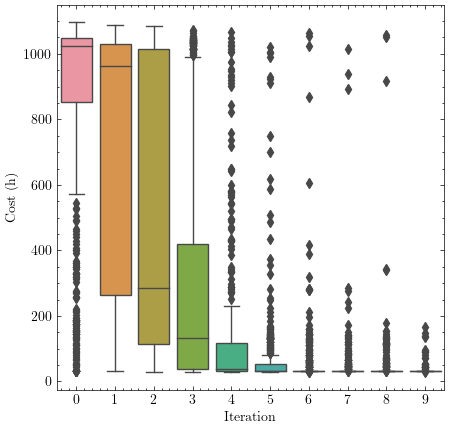

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plot_costs(costs_arr, cost_name="Cost (h)", ax=ax)
plt.savefig("figures/nopriority_genarrivals_meantt_boxplot")
plt.show()

# Predicted Arrivals

In [84]:
# load data
data = pd.read_csv("final_miami_datasets/no_history_filled/train.csv", index_col=[0,1])
vessel_lengths = pd.read_csv("final_miami_datasets/vessels_lengths.csv", index_col=0)

# get vessel nums from voyages ids
vessel_nums = data.index.get_level_values(0).to_series().str.split("-", expand=True)[0].astype(int)
data = data.assign(vessel=vessel_nums.values)

# join vessel lengths to data based on vessel num
data = data.join(vessel_lengths, on="vessel")

# keep only wanted variables
data = data[["vessel", "Length", "LON", "LAT", "SOG", "COG", "distanceToPort"]]

In [85]:
display(data.head())
display(vessel_lengths.head())

vessel  Length        LON        LAT       SOG  \
voyage_id BaseDateTime                                                          
3-0       2018-03-22 00:00:00       3   166.0 -83.810500  23.033580  19.80000   
          2018-03-22 00:02:00       3   166.0 -83.801700  23.039690  19.70000   
          2018-03-22 00:04:00       3   166.0 -83.792970  23.045705  19.66605   
          2018-03-22 00:06:00       3   166.0 -83.784240  23.051720  19.90000   
          2018-03-22 00:08:00       3   166.0 -83.773435  23.059095  19.85000   

                                     COG  distanceToPort  
voyage_id BaseDateTime                                    
3-0       2018-03-22 00:00:00  53.800000      284.212507  
          2018-03-22 00:02:00  52.900000      283.550492  
          2018-03-22 00:04:00  53.175636      282.895657  
          2018-03-22 00:06:00  52.900000      282.240824  
          2018-03-22 00:08:00  53.500000      281.433224

,Length
1,134.0
2,90.0
3,166.0
4,194.0
5,294.0


In [86]:
exec_moment = data["LON"].groupby(level=1, sort=False).count().idxmax()

In [87]:
exec_moment_samples = data.loc[data.index.get_level_values(1) == exec_moment]
exec_moment_voyages = data.loc[data.index.get_level_values(0).isin(exec_moment_samples.index.get_level_values(0))]

voyage_points = gpd.points_from_xy(exec_moment_voyages["LON"], exec_moment_voyages["LAT"], crs=4326)
exec_points = gpd.points_from_xy(exec_moment_samples["LON"], exec_moment_samples["LAT"], crs=4326)

gdf_voyage_points = gpd.GeoDataFrame(voyage_points, geometry=voyage_points)
gdf_exec_points = gpd.GeoDataFrame(exec_points, geometry=exec_points)

<ipython-input-88-de7ea7ef0c36>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


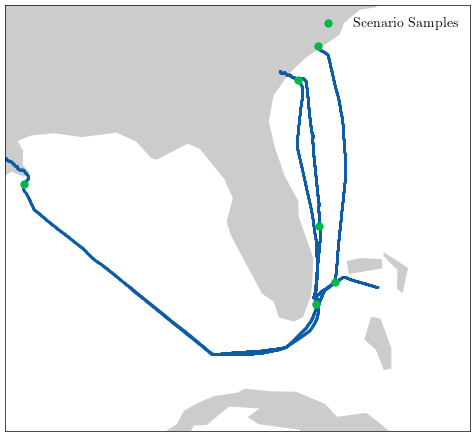

In [88]:
fig, ax = plt.subplots(figsize=(6, 6))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot(ax=ax, alpha=0.4, color="grey")

gdf_voyage_points.plot(markersize=0.5, ax=ax)
gdf_exec_points.plot(markersize=25, label="Scenario Samples", ax=ax)

plt.xlim([-90, -75])
plt.ylim([22, 34])
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])

plt.legend()

plt.savefig("figures/BerthAllocation/scenario_map")
plt.show()

In [89]:
exec_moment_samples[["Length", "LON", "LAT", "SOG", "COG", "distanceToPort"]]

,,Length,LON,LAT,SOG,COG,distanceToPort
voyage_id,BaseDateTime,,,,,,
5-1,2018-06-13 05:02:00,294.0,-80.540550,31.880290,18.65,136.00,420.161372
36-1,2018-06-13 05:02:00,352.0,-79.890030,32.837200,0.00,200.10,487.900942
49-2,2018-06-13 05:02:00,366.0,-79.855200,27.763245,8.50,162.65,135.442886
59-1,2018-06-13 05:02:00,304.0,-79.965870,25.580380,4.95,6.00,17.207222
60-3,2018-06-13 05:02:00,304.0,-89.400105,28.947305,12.70,160.40,595.590601
219-4,2018-06-13 05:02:00,279.0,-79.338925,26.201140,11.35,186.90,57.156373


In [90]:
rtt_pred_model = joblib.load("models/mlp_pipe_trained.pkl")

In [91]:
vessels_ids, arrival_times, handling_times, priorities = get_scenario(exec_moment, data, rtt_pred_model, prioritize=True)

n_berths = 3
efficiency_interval = np.random.uniform(low=1, high=1.5, size=n_berths)
handling_times = np.dot(handling_times[:, np.newaxis], efficiency_interval[np.newaxis, :])
init_berth_occupancy = np.zeros(n_berths)

n_ships_state = vessels_ids.shape[0]
input_dim = n_ships_state*2
output_dim = n_ships_state

policy_model = LogisticRegression(input_dim=input_dim, output_dim=output_dim)

In [92]:
print(vessels_ids)
print(exec_moment_samples["Length"].values)
print(arrival_times)
print(handling_times)

[  5.  36.  49.  59.  60. 219.]
[294. 352. 366. 304. 304. 279.]
[25.76957084 36.43975993 18.16906627  6.98031105 38.79355073  9.31056679]
[[25.93856826 25.40296969 26.93359794]
 [37.70018378 36.92172274 39.1464009 ]
 [37.30708638 36.53674231 38.73822389]
 [64.61918224 63.28487799 67.09803933]
 [58.41942562 57.21313849 60.66045378]
 [34.26926177 33.56164492 35.58386525]]


In [93]:
scenario_data_arr = np.hstack((exec_moment_samples["Length"].values[:, np.newaxis], priorities[:, np.newaxis],
                          arrival_times[:, np.newaxis], handling_times))

In [94]:
pd.DataFrame(columns=["Length", "Priority", "Remaining Travel Time (h)",
                      "Hadling Time B1 (h)", "Hadling Time B2 (h)", "Hadling Time B3 (h)"],
             index=vessels_ids,
             data=scenario_data_arr)

,Length,Priority,Remaining Travel Time (h),Hadling Time B1 (h),Hadling Time B2 (h),Hadling Time B3 (h)
5.0,294.0,2.0,25.769571,25.938568,25.402970,26.933598
36.0,352.0,3.0,36.439760,37.700184,36.921723,39.146401
49.0,366.0,3.0,18.169066,37.307086,36.536742,38.738224
59.0,304.0,3.0,6.980311,64.619182,63.284878,67.098039
60.0,304.0,3.0,38.793551,58.419426,57.213138,60.660454
219.0,279.0,2.0,9.310567,34.269262,33.561645,35.583865


## No Priorities

In [95]:
costs_agg=np.array([np.mean, np.mean, np.mean])
costs_weights=np.array([1, 1, 1])

ba = BerthAllocator(vessels_ids=vessels_ids, arrival_times=arrival_times, handling_times=handling_times,
                    priorities=np.ones(vessels_ids.shape[0]), init_berth_occupancy=init_berth_occupancy,
                    policy_model=policy_model)

bpe = BerthPlanEvaluator(costs_agg=costs_agg, costs_weights=costs_weights)

cem = CrossEntropyMethod(n_iter=10, n_vectors=500, elite_fraction=0.5)

In [96]:
best_parameters, best_cost, costs_arr, time_exec_arr = cem.optimize(ba, bpe)

In [97]:
# optimization results
print(f"Best Cost: {best_cost}")
print(f"Best Cost Per Iter: {np.min(costs_arr, axis=1)}")
print(f"Execution Time per Iteration: {np.mean(time_exec_arr)}")

Best Cost: 65.39303981173023
Best Cost Per Iter: [65.39303981 65.46419395 65.39303981 65.46419395 65.46419395 65.46419395
 65.46419395 65.46419395 65.46419395 65.46419395]
Execution Time per Iteration: 7.995265769958496


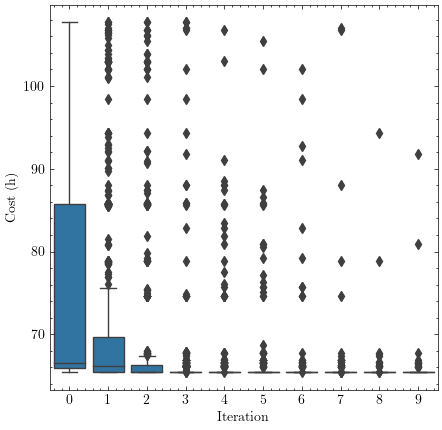

In [98]:
fig, ax = plt.subplots(figsize=(5,5))
plot_costs(costs_arr, cost_name="Cost (h)", ax=ax)
plt.savefig("figures/nopriority_originalarrivals_boxplot")
plt.show()

In [99]:
# final simulation
berth_plan = ba.simulate(best_parameters)
overall_cost, waiting_time, turnaround_time, idle_time = bpe.get_costs(berth_plan, ba.init_berth_occupancy, partial_costs=True)

In [100]:
print(f"Best Cost: {overall_cost}")
print(f"Mean Waiting Time: {waiting_time}")
print(f"Mean Turnaround Time: {turnaround_time}")
print(f"Mean Idle Time: {idle_time}")

Best Cost: 65.39303981173023
Mean Waiting Time: 11.133525411658475
Mean Turnaround Time: 54.25951440007176
Mean Idle Time: 4.736951571734001e-15


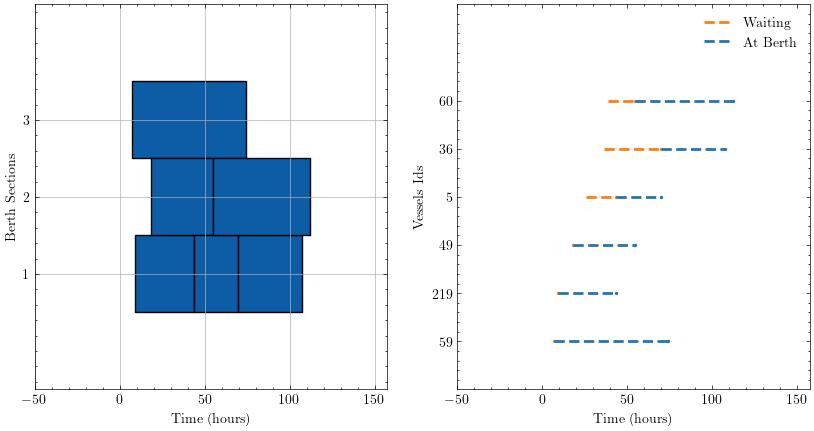

In [101]:
last_berthed_vessel = berth_plan.iloc[np.argmax(berth_plan["BerthingTime"].values)]
max_moment = last_berthed_vessel["BerthingTime"] + last_berthed_vessel["HandlingTime"]
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_plan(berth_plan, max_moment, 3, axs)
plt.savefig("figures/nopriority_originalarrivals_berthplan")
plt.show()

## Priorities

In [102]:
costs_agg=np.array([np.mean, np.mean, np.mean])
costs_weights=np.array([1, 1, 1])

arrival_times[0] = arrival_times[1]

ba = BerthAllocator(vessels_ids=vessels_ids, arrival_times=arrival_times, handling_times=handling_times,
                    priorities=np.ones(vessels_ids.shape[0]), init_berth_occupancy=init_berth_occupancy,
                    policy_model=policy_model)

bpe = BerthPlanEvaluator(costs_agg=costs_agg, costs_weights=costs_weights)

cem = CrossEntropyMethod(n_iter=10, n_vectors=500, elite_fraction=0.5)

In [103]:
# run without priorities
best_parameters, best_cost, costs_arr, time_exec_arr = cem.optimize(ba, bpe)

In [104]:
print(f"Best Cost: {best_cost}")
print(f"Best Cost Per Iter: {np.min(costs_arr, axis=1)}")
print(f"Execution Time per Iteration: {np.mean(time_exec_arr)}")

Best Cost: 61.83631011506343
Best Cost Per Iter: [61.83631012 61.83631012 61.90746425 61.90746425 61.90746425 61.90746425
 61.90746425 61.90746425 61.90746425 61.90746425]
Execution Time per Iteration: 7.975717449188233


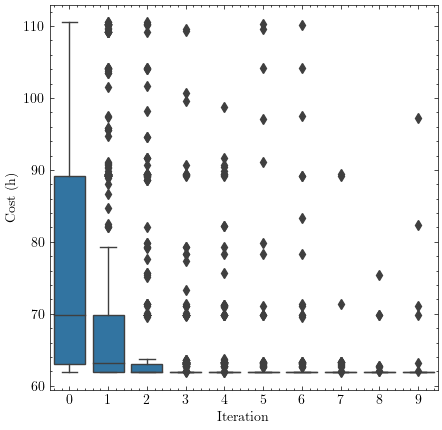

In [105]:
fig, ax = plt.subplots(figsize=(5,5))
plot_costs(costs_arr, cost_name="Cost (h)", ax=ax)
plt.savefig("figures/nopriority_modifiedarrivals_boxplot")
plt.show()

In [106]:
berth_plan = ba.simulate(best_parameters)
overall_cost, waiting_time, turnaround_time, idle_time = bpe.get_costs(berth_plan, ba.init_berth_occupancy, partial_costs=True)

In [107]:
print(f"Best Cost: {overall_cost}")
print(f"Mean Waiting Time: {waiting_time}")
print(f"Mean Turnaround Time: {turnaround_time}")
print(f"Mean Idle Time: {idle_time}")

Best Cost: 61.83631011506343
Mean Waiting Time: 9.355160563325073
Mean Turnaround Time: 52.48114955173835
Mean Idle Time: 4.736951571734001e-15


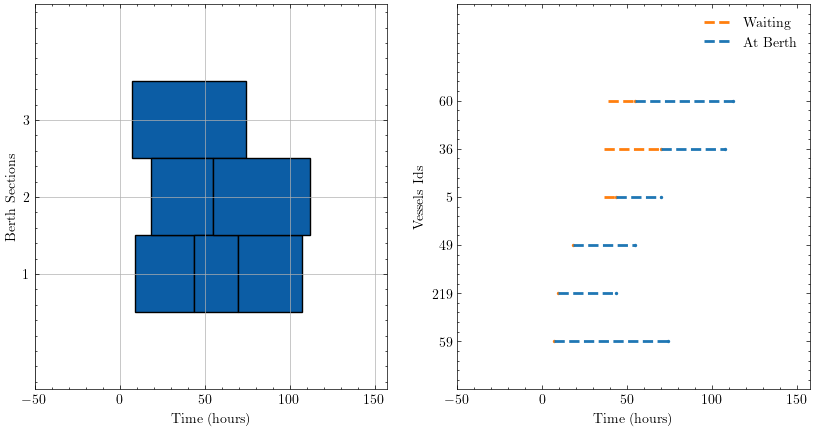

In [108]:
last_berthed_vessel = berth_plan.iloc[np.argmax(berth_plan["BerthingTime"].values)]
max_moment = last_berthed_vessel["BerthingTime"] + last_berthed_vessel["HandlingTime"]
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_plan(berth_plan, max_moment, 3, axs)
plt.savefig("figures/nopriority_modifiedarrivals_berthplan")
plt.show()

In [109]:
ba = BerthAllocator(vessels_ids=vessels_ids, arrival_times=arrival_times, handling_times=handling_times,
                    priorities=priorities, init_berth_occupancy=init_berth_occupancy,
                    policy_model=policy_model)

bpe = BerthPlanEvaluator(costs_agg=costs_agg, costs_weights=costs_weights)

cem = CrossEntropyMethod(n_iter=10, n_vectors=500, elite_fraction=0.5)

In [110]:
# run without priorities
best_parameters, best_cost, costs_arr, time_exec_arr = cem.optimize(ba, bpe)

In [111]:
print(f"Best Cost: {best_cost}")
print(f"Best Cost Per Iter: {np.min(costs_arr, axis=1)}")
print(f"Execution Time per Iteration: {np.mean(time_exec_arr)}")

Best Cost: 167.07196202690773
Best Cost Per Iter: [167.49280607 167.07196203 167.07196203 167.07196203 167.07196203
 167.07196203 167.07196203 167.07196203 167.07196203 167.48930216]
Execution Time per Iteration: 8.008870458602905


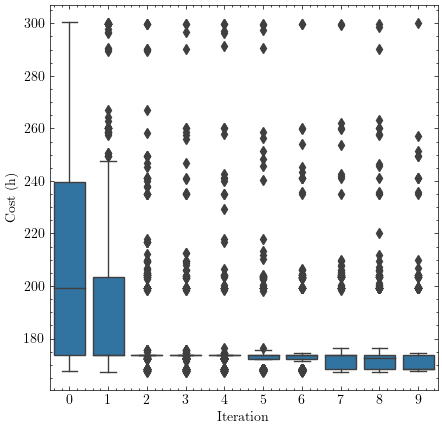

In [116]:
fig, ax = plt.subplots(figsize=(5,5))
plot_costs(costs_arr, cost_name="Cost (h)", ax=ax)
plt.savefig("figures/priority_modifiedarrivals_boxplot")
plt.show()

In [113]:
berth_plan = ba.simulate(best_parameters)
overall_cost, waiting_time, turnaround_time, idle_time = bpe.get_costs(berth_plan, ba.init_berth_occupancy, partial_costs=True)

In [114]:
print(f"Best Cost: {overall_cost}")
print(f"Mean Waiting Time: {waiting_time}")
print(f"Mean Turnaround Time: {turnaround_time}")
print(f"Mean Idle Time: {idle_time}")

Best Cost: 167.07196202690773
Mean Waiting Time: 9.921110557128989
Mean Turnaround Time: 53.094093466066816
Mean Idle Time: 0.0


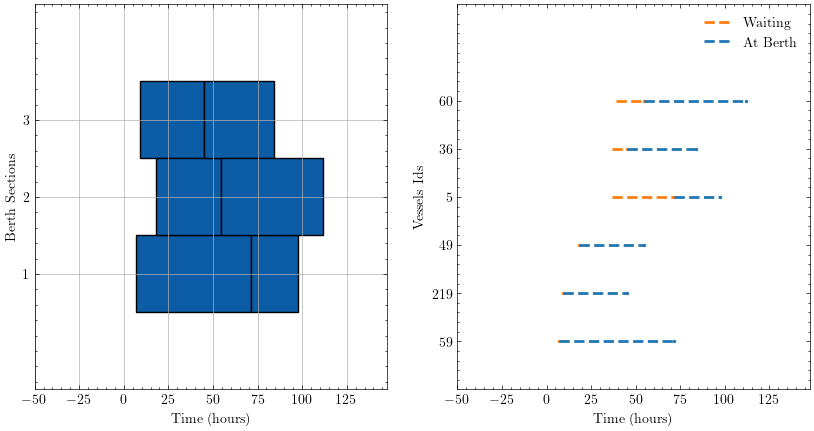

In [115]:
last_berthed_vessel = berth_plan.iloc[np.argmax(berth_plan["BerthingTime"].values)]
max_moment = last_berthed_vessel["BerthingTime"] + last_berthed_vessel["HandlingTime"]
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_plan(berth_plan, max_moment, 3, axs)
plt.savefig("figures/priority_modifiedarrivals_berthplan")
plt.show()